# Debut

In [219]:
def random_float(min=0, max=9):
    import random
    entier = random.randint(min, max)
    float_ = random.random()
    return entier+float_

In [220]:
class Position():
    def __init__(self, longitude, lattitude):
        self.longitude = longitude
        self.lattitude = lattitude
    def __str__(self):
        return "(lon:%.2f lat:%.2f)"%(self.longitude, self.lattitude)
    def is_same_position(self, other):
        return self.lattitude==other.lattitude and self.longitude==other.longitude


# 1) Logger

In [221]:
class Logger():
    def __init__(self, path, bufferlength=1, separator="\n", mode="a"):
        import os
        if os.path.exists(path) :
            msg = "Attention : vous allez utiliser un fichier existant !"
            print (msg)
            if (mode != "a"):
                raise msg
        self.path         = path
        self.logs         = []
        self.bufferlength = bufferlength
        self.separator    = separator

    def clean_msg(self, msg):
        msg = str(msg)
        if msg[-1] != "\n": 
            msg = msg + "\n"
        return msg
    
    def log(self, msg):
        print(msg)
        msg = self.clean_msg(msg)
        import datetime
        msg=str(datetime.datetime.now().isoformat())+","+msg
        self.logs.append(msg)
        if self.bufferlength < len(self.logs):
            self.write_to_disk()
    
    def write_to_disk(self):
        with open(self.path, "a") as f:
            f.writelines(self.logs)
        self.logs= []
    
    def __del__(self):
        self.write_to_disk()
                

In [222]:
def get_random_position(x_max, y_max):
    return Position(random_float(0, y_max), random_float(0, y_max))

# 2) Velo

In [223]:
class Velo:
    nb_d_instance =0
    def __init__(self):
        import random
        Velo.nb_d_instance += 1
        self.id             = "velo_%s"%(Velo.nb_d_instance)
        self.performance    = random.random()
    def update_performance(self):
        import numpy as np
        self.performance = np.random.normal(0.75, 0.2)
    def __str__(self):
        return "{id} : performance = {performance}".format(id=self.id,performance=self.performance)

# Velo - test

In [224]:
def test_velo():
    v = Velo()
    perfs = [(v.update_performance(), v.performance)[1] for x in range(10)]
    print(perfs)
test_velo()

[0.40341286274801974, 1.0510347801413578, 1.053757058918504, 0.9603452918751871, 0.9926083256118212, 0.617792883585531, 0.9565407959400185, 0.6264302765543901, 0.5482055294773319, 0.7817642397757032]


# 3) Trajet

In [225]:
%matplotlib inline

(lon:0.10 lat:0.10)
(lon:0.20 lat:0.20)
(lon:0.30 lat:0.30)
(lon:0.40 lat:0.40)
(lon:0.50 lat:0.50)
(lon:0.60 lat:0.60)
(lon:0.70 lat:0.70)
(lon:0.80 lat:0.80)
(lon:0.90 lat:0.90)
(lon:1.00 lat:1.00)
(lon:1.00 lat:1.00)


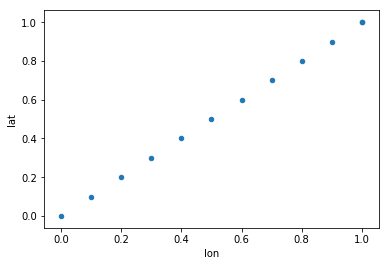

In [226]:
p1 = Position(0,0)
p2 = Position(1,1)
t = Trajet(p1,p2, 1)
r = [t.position]
while not t.fini():
    t.next_position()
    r.append(t.position)
    print(t.position)
draw(r)

In [227]:
class Trajet():
    def __init__(self, position_depart, position_arrivee, vitesse=3):
        self.depart      = position_depart
        self.destination = position_arrivee
        self.nb_step     = min(10, 10/vitesse)
        self.set_position(position_depart)
        self.set_distance() 
        self.set_pas()
        self.avancee_minimale = 0.1
    def __str__(self):
        return "%s -> %s"%(self.depart, self.destination)
    def fini(self):
        return self.position.is_same_position(self.destination)
        
    def set_position(self, position):
        self.longitude   = position.longitude
        self.lattitude   = position.lattitude
        self.position    = position
        
    def set_pas(self):
        """
        @Todo : ici le point d'arrivée est toujours atteint en 3 temps.
        Il faudrait le rendre dépendant de la distance.
        => rajouter un paramètre de vitesse ? 
        """
        nb_step            = self.nb_step
        delta_longitude    = self.destination.longitude  - self.longitude
        delta_lattitude    = self.destination.lattitude  - self.lattitude
        
        self.pas_longitude = delta_longitude * 1/ nb_step
        self.pas_lattitude = delta_lattitude * 1/ nb_step
        
    def set_distance(self):
        import math
        delta_longitude = self.destination.longitude  - self.longitude
        delta_lattitude = self.destination.lattitude  - self.lattitude
        distance        = math.sqrt(math.pow(delta_longitude, 2) + math.pow(delta_lattitude, 2))
        self.distance   = distance
        return distance
        
    def next_position(self):
        last_distance = self.set_distance() 
        if self.distance < self.avancee_minimale:
            self.set_position(self.destination)
            return self.destination
        else:
            new_longitude   = self.longitude + self.pas_longitude
            new_latitude    = self.lattitude + self.pas_lattitude
            new_position    = Position(new_longitude, new_latitude)
            self.set_position(new_position)
            new_distance    = self.set_distance()
            if not new_distance<last_distance:
                new_position = self.destination
                self.set_position(new_position)
            return new_position

# 4) Station

In [280]:
class Station:
    nb_d_instance =0
    station_logger=Logger("./stations.csv")
    def __init__(self, position):
        import random
        Station.nb_d_instance +=1
        NB_BORNES_POSSIBLES = [5,10,15,20,30]
        self.position       = position
        self.nb_bornes      = random.choice(NB_BORNES_POSSIBLES)
        self.velos          = [Velo() for i in range(self.nb_bornes-3)]
        self.id             = Station.nb_d_instance
    def __str__(self):
        to_print = "Station n° {nom} : {position}, {nb_bornes} bornes, {nb_velos_dispo} velos"
        
        return to_print.format(nom=self.id,
                               position=self.position,
                              nb_bornes=self.nb_bornes,
                              nb_velos_dispo=len(self.velos))
    def nb_de_velos(self):
        return len(self.velos)

    def has_empty_place(self):
        return len(self.velos) < self.nb_bornes

    def has_velo(self):
        return 0 < len(self.velos)
    def log(self, message):
        message="station_%s : %s"%(self.id, message)
        Station.station_logger.log(message)
        
    def deposer_un_velo(self, velo):
        if self.has_empty_place():
            velo.update_performance()
            self.velos.append(velo)
            self.log("recupere le velo %s"%velo.id)
            return True
        else:
            self.log("complete")
            return False
    def prendre_un_velo(self):
        if self.has_velo():
            velo = self.velos.pop()
            self.log("donne le velo %s"%velo.id)
            return velo
        else:
            self.log("vide.")
            return False

    def nb_velo_under_perf(self, seuil_de_performance=0.5):
        test = lambda velo: velo.performance < seuil_de_performance
        return len(list(filter(test, self.velos)))
        

Attention : vous allez utiliser un fichier existant !


# 5) Prestataire

In [229]:
class Prestataire():
    def __init__(self, largeur=10, hauteur=10):
        self.largeur = largeur
        self.hauteur = hauteur
        self.reseau = []
        for lattitude in range(self.hauteur):
            for longitude in range(self.largeur):
                emplacement = Position(lattitude, longitude)
                new_station = Station(emplacement)
                self.reseau.append(new_station)
    
    def is_position_a_station(self, position):
        nb_ligne = round(position.longitude)
        nb_col   = round(position.lattitude)
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        if nb_ligne<0 or nb_col<0:
            return False    
        
        closest_station  = self.reseau[int(indice)]
        return closest_station.position.is_same_position( position)

    def get_station_at_position(self, position):
        nb_ligne = round(position.longitude)
        nb_col   = round(position.lattitude)
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        return self.reseau[int(indice)]
        
    def get_closest_station(self, position):
        """
        @Todo : améliorer pour les valeurs en dehors du réseau
        """
        nb_ligne = round(position.longitude)
        nb_col   = round(position.lattitude)
        indice   =  (nb_ligne * self.largeur) + (nb_col )
        if nb_ligne<0 or nb_col<0:
            closest_station  = self.reseau[0]    
        try:
            closest_station  = self.reseau[int(indice)]
            if is_same_position(closest_station.position, position):
                print("same position")
                closest_station = self.reseau[int(indice)+1]
        except Exception as e:
            print("Pbm dans get_closest_station :", e)
            closest_station  = self.reseau[-1]
        return closest_station
    

    def filtrer_le_reseau(self, function_de_test):
        """
        Renvoie les stations qui passe le test.
        
        Parameters:
            function de test : lambda function
        Return:
            list
        
        """
        return list(filter(function_de_test, self.reseau))
    def nb_station_passant_le_test(self, function):
        r = self.filtrer_le_reseau(function)
        return len(r)
    
    def nombre_de_stations(self):
        return len(self.reseau)
    
    def nombre_de_velos(self):
        return sum(map(lambda x: x.nb_de_velos(),self.reseau))
    
    def nombre_de_stations_pleine(self):
        test  = lambda station: station.nb_bornes == len(station.velos)
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_avec_velo(self):
        test = lambda x: x.has_velo()
        return self.nb_station_passant_le_test(test)
    
    def nombre_de_stations_vide(self):
        test  = lambda station: not station.has_velo()
        return self.nb_station_passant_le_test(test)

    def __str__(self):
        return """
                Nb de stations           : %s 
                Nb de vélos              : %s 
                Nb de stations avec vélo : %s 
                Nb de stations pleines   : %s
                Nb de stations vides     : %s
        """%(self.nombre_de_stations(),
             self.nombre_de_velos(),
             self.nombre_de_stations_avec_velo(),
             self.nombre_de_stations_pleine(),
             self.nombre_de_stations_vide())
    
    def nombre_de_velos_sous_performants(self, seuil=0.5):
        r = map(lambda station: station.nb_velo_under_perf(seuil), self.reseau)
        return sum(list(r))
    def get_topology(self):
        """
        Return a Datframe of longitude/lattitude
        """
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.reseau]}
        
        return pd.DataFrame(infos)
        
        
    

# 4.1) Test decaux

In [230]:
def draw(positions):
    import pandas as pd
    df = pd.DataFrame([ {"lon" : x.longitude, 
                "lat": x.lattitude} for x in positions])
    df.plot.scatter(x="lon", y="lat")
    
    

In [231]:
r = Prestataire(3,3)

# 6) Villes

In [232]:
class Ville:
    def __init__(self, nb_de_cyclistes, Prestataire):
        self.prestataire = Prestataire
        self.x_max = Prestataire.largeur -2
        self.y_max = Prestataire.hauteur-2
        self.cyclistes   = [Cycliste(get_random_position(self.x_max, self.y_max), get_random_position(self.x_max, self.y_max), self) for i in range(nb_de_cyclistes)]
        self.ax = None
    def __str__(self):
        return "\n".join([str(self.prestataire),
                    str(self.x_max), 
                       str(self.y_max),
                   "nb de cycliste = ", str(len(self.cyclistes))])
        
    def reveil(self):
        list(map(lambda cycliste : cycliste.avancer(), self.cyclistes))
        
    def get_cycliste_workplaces(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.travail.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.travail.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_cycliste_homes(self):
        import pandas as pd
        infos = { "longitudes" : [cycliste.home.longitude for cycliste in self.cyclistes],
                  "lattitude"  : [cycliste.home.lattitude for cycliste in self.cyclistes]}
        return pd.DataFrame(infos)

        
    def get_cycliste_positions(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.cyclistes],
                  "lattitude"  : [x.position.lattitude for x in self.cyclistes]}
        return pd.DataFrame(infos)

    def get_topology(self):
        import pandas as pd
        infos = { "longitudes" : [x.position.longitude for x in self.prestataire.reseau],
                  "lattitude"  : [x.position.lattitude for x in self.prestataire.reseau]}
        return pd.DataFrame(infos)
    def get_drawing_data(self):
        cyclistes  = self.get_cycliste_positions()
        stations   = self.get_topology()
        homes      = self.get_cycliste_homes()
        workplaces = self.get_cycliste_workplaces()
        return cyclistes, stations, homes, workplaces

    def draw_map(self,ax=None):
        import matplotlib.pyplot as plt
        cyclistes, stations, homes, workplaces = self.get_drawing_data()
        if not ax:
            ax = stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.4)
        else:
            stations.plot.scatter(      x="longitudes", y="lattitude", c="grey"   , marker="D", alpha=0.1, ax=ax)
        homes.plot.scatter(         x="longitudes", y="lattitude", c="green"  , marker="s", ax=ax )
        workplaces.plot.scatter(    x="longitudes", y="lattitude", c="red"    , marker="x", ax=ax )
        cyclistes.plot.scatter(x="longitudes", y="lattitude", c="blue", marker="1"        , ax=ax)
        fig = plt.gcf()
        fig.suptitle(str(cyclistes))
        return ax
        

# 7) Cycliste

In [369]:
class Cycliste:
    nb_d_instance =0
    cycliste_logger= Logger("./cyclistes.csv")
    def __init__(self, position_home, position_travail, ville):
        import random
        import numpy as np
        Cycliste.nb_d_instance +=1
        self.id           = Cycliste.nb_d_instance
        self.home         = position_home
        self.travail      = position_travail
        self.est_en_route = False
        self.position     = position_home
        self.destination  = position_travail
        self.sur_velo     = False
        self.velo         = False
        self.sexe         = random.choice(["H", "F"])
        self.age          = random.choice(range(15,85))
        self.sportivite   = np.random.normal(2, 2)
        self.vitesse_a_pied = 2 * self.sportivite 
        self.vitesse_a_velo = 5 * self.sportivite
        self.ville        = ville
        self.trajet       = Trajet(self.home, self.home)
    def __str__(self):
        return " %s :  %s" %(self.id,  str(self.position))
    
    def vitesse(self):
        if self.sur_velo:
            return self.vitesse_a_velo
        else:
            return self.vitesse_a_pied
        
    def est_a_la_maison(self):
        return self.position == self.home
    
    def est_au_travail(self):
        return self.position == self.travail
    
    def est_arrive(self):
        return self.position == self.destination_finale
    
    def log(self, message):
        message="cycliste_%s : %s"%(self.id, message)
        Cycliste.cycliste_logger.log(message)
    def est_sur_station(self):
        return self.ville.prestataire.is_position_a_station(self.position)

    def ou_suis_je(self):
        if self.est_a_la_maison():
            return " a la maison"
        if self.est_au_travail():
            return " au travail"

        return " en route"
        
    def ou_vais_je(self):
        if self.destination == self.travail:
            return " au travail"
        if self.destination == self.home:
            return " a la maison"
        

    def avancer(self, debug=False):
        if not self.trajet.fini():
            self.position = self.trajet.next_position()
        else:            
            if self.est_a_la_maison():
                self.destination        = self.ville.prestataire.get_closest_station(self.position).position
                self.destination_finale = self.travail
                self.sur_velo           = False
                self.trajet             = Trajet(self.home, self.destination)

            if self.est_au_travail():
                self.destination        = self.ville.prestataire.get_closest_station(self.position).position
                self.destination_finale = self.home
                self.sur_velo           = False
                self.trajet             = Trajet(self.travail, self.destination)

            if self.est_sur_station():
                station_actuelle = self.ville.prestataire.get_station_at_position(self.position)
                
                if self.sur_velo:
                    velo_rendu       = station_actuelle.deposer_un_velo(self.velo)
                    if velo_rendu:
                        self.sur_velo    = False
                        self.velo        = False
                        self.destination = self.destination_finale
                    else:
                        self.destination = self.ville.prestataire.get_closest_station(self.position).position
                else:
                    velo_pris = station_actuelle.prendre_un_velo()
                    if velo_pris:
                        self.sur_velo    = True
                        self.velo        = velo_pris
                        self.destination = self.ville.prestataire.get_closest_station(self.destination_finale).position
                    else:
                        self.destination = self.ville.prestataire.get_closest_station(self.position).position 
                        
                self.trajet      = Trajet(self.position, self.destination)
                    
                    
                    
                    
                    
                    
                    
                    
                    

Attention : vous allez utiliser un fichier existant !


# 7) Algo

In [295]:
def is_same_position(p1, p2):
    return p1.lattitude==p2.lattitude and p1.longitude==p2.longitude

import pandas as pd

In [296]:
%matplotlib inline

In [370]:
JcDecaux = Prestataire(4,4)
print(JcDecaux)
paris = Ville(1, JcDecaux)
positions = pd.DataFrame()



                Nb de stations           : 16 
                Nb de vélos              : 267 
                Nb de stations avec vélo : 16 
                Nb de stations pleines   : 0
                Nb de stations vides     : 0
        


id 1
home (lon:2.15 lat:1.58)
travail (lon:1.49 lat:2.78)
est_en_route False
position (lon:2.10 lat:1.71)
destination (lon:2.00 lat:2.00)
sur_velo False
velo False
sexe F
age 20
sportivite 3.2775961544038967
vitesse_a_pied 6.5551923088077935
vitesse_a_velo 16.387980772019482
ville 
                Nb de stations           : 16 
                Nb de vélos              : 267 
                Nb de stations avec vélo : 16 
                Nb de stations pleines   : 0
                Nb de stations vides     : 0
        
2
2
nb de cycliste = 
1
trajet (lon:2.15 lat:1.58) -> (lon:2.00 lat:2.00)
destination_finale (lon:1.49 lat:2.78)
(lon:2.10 lat:1.71)


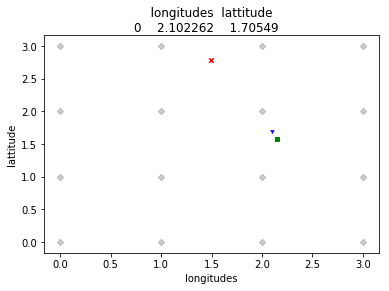

In [372]:
paris.reveil()
dico = paris.cyclistes[0].__dict__
for k in dico:
    print(k, dico[k])
print(dico["position"])
paris.draw_map()

------------------------------
------------------------------
------------------------------
------------------------------
------------------------------


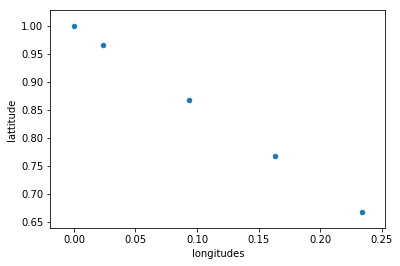

In [189]:
for i in range(5):
    paris.reveil()
    #paris.draw_map()
    positions = positions.append(paris.get_cycliste_positions())
    print("-"*30)
positions.plot.scatter(x="longitudes", y="lattitude")

In [ ]:
if False:
    path_to_cyclistes = "./cyclistes.csv"
    logger_ = Logger(path_to_cyclistes)
    infos_voulues = ["id", "sexe", "sportivite", "age", "sur_velo"]
    to_write      = ",".join(infos_voulues)
    logger_.log(to_write)
    for cycliste in paris.cyclistes:
        dico          = cycliste.__dict__        
        infos         = [str(dico[voulue]) for voulue in infos_voulues]
        to_write      = ",".join(infos)
        logger_.log(to_write)


# Exemple de dataFrame pandas

In [121]:
c = paris.cyclistes[0]

In [122]:
str(c.position)

'(lon:5.21 lat:8.89)'

In [123]:
print(c.ville.prestataire.get_closest_station(c.position))

Station n° 669 : (lon:5.00 lat:9.00), 30 bornes, 30 velos


In [124]:
c.ville.prestataire.get_topology()

,longitudes,lattitude
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
5,0,5
6,0,6
7,0,7
8,0,8
9,0,9


In [ ]:
logger_.write_to_disk()


In [31]:
import pandas as pd

In [32]:
dico = {}
for i in range(12):
    seuil       = float(i/10)
    nb_velo     = test_reseau.nombre_de_velos_sous_performants(seuil)
    dico[seuil] = nb_velo

NameError: name 'test_reseau' is not defined

In [ ]:
%matplotlib inline
pd.DataFrame(dico, index=range(12)).T[0].plot(kind='bar')